# A Brief guide to JAX
Author: Reinhardt Palko

Date: 13 October 2022

## Introduction

JAX is a high-performance, numerical computing library incorporating composable function transformations developed by the Google Research team. This notebook is a tutorial of the JAX framework, which at the time of writing, is still in an experimental phase. Here we hope to provide a guide on the basic JAX functions: `grad()`, `jit()`, `vmap()`, and `pmap()`. We also hope to provide some more primitive JAX functions which we found useful in some of our work.
Also, JAX still has quirks which one needs to get used to. Here we try to provide some simple explanations to those bits. Note that this is a summary of various resources used from the official documentation to other tutorials. The links of which will be provided in the resources section.

## Table of contents
- Installing JAX
- JAX as a wrapper for NumPy and SciPy
- 

## Resources 
- [Official JAX Website](https://jax.readthedocs.io/en/latest/index.html)
- [Why You Should (or Shouldn't) be Using Google's JAX in 2022](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)
- [Machine Learning with JAX - From Zero to Hero | Tutorial #1](https://youtu.be/SstuvS-tVc0)
- [JAX Crash Course - Accelerating Machine Learning code!](https://youtu.be/juo5G3t4qAo)

## What Is JAX?


## Installing JAX

To be able to use JAX, one requires the `jaxlib` package. At the time of writing, `jaxlib` is supported on Linux (Ubuntu 16.04 or later) and macOS (10.12 or later) platforms. Windows users can use JAX on CPU and GPU via the Windows Subsystem for Linux. To install JAX on CPU, one can run the following code:

In [1]:
pip install --upgrade pip
pip install --upgrade "jax[cpu]"

SyntaxError: ignored

To install the JAX version with Nvidia GPU support, one must first install [CUDA](https://developer.nvidia.com/cuda-downloads) and [CuDNN](https://developer.nvidia.com/cudnn).

In [2]:
pip install --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
# Note: wheels only available on linux.
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

SyntaxError: ignored

If any installation issues persist, consult the documentation https://github.com/google/jax#installation.

## JAX as a wrapper for NumPy and SciPy

Numpy and Scipy are two of the most common packages used for scientific computing. JAX provides wrappers for both of these functions, which means we can use (almost) all the functionality of `numpy` and `scipy` in JAX, meaning we have `jax.numpy` and `jax.scipy` respectively. 
>
First, we provide an example of regular `numpy` and then show how to use `jax.numpy`. Take a look at the example where we plot a simple `np.array`.

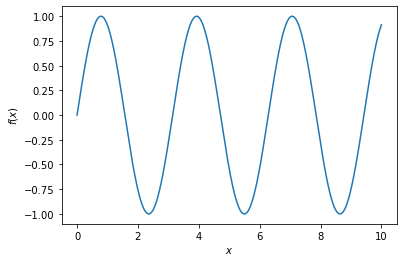

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.show()

Now, using the exact same methodology as above, we can use `jax.numpy`.

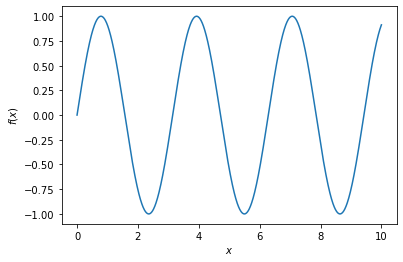

In [4]:
import jax
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.show()

The JAX wrapper of numpy even allows us to use JAX functions to do computations on regular `numpy` arrays. Meaning that we can use our pre-existing numpy code and use `jax` as a wrapper for faster computations. 

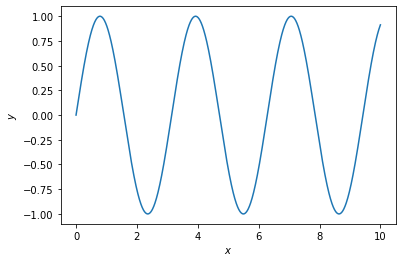

In [5]:
# regular numpy array
x_np = np.linspace(0, 10, 1000)

# jax functions on a the numpy array
y_jnp = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_jnp, y_jnp)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In the same way that JAX provides a wrapper for NumPy, we can use SciPy as well. Here we show the example of how one can plot the Normal distributions using regular `scipy` and `jax.scipy`.

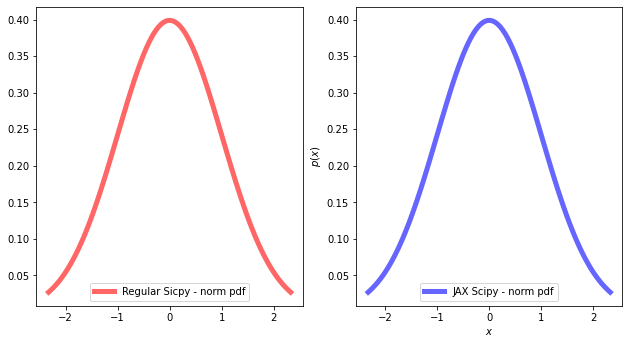

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10.5, 5.5)

# scipy version
from scipy.stats import norm
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
ax[0].plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='Regular Sicpy - norm pdf')
ax[0].legend()

# jax.scipy version
from jax.scipy.stats import norm as jnorm
x = jnp.linspace(jnorm.ppf(0.01), jnorm.ppf(0.99), 100)
ax[1].plot(x, jnorm.pdf(x),'b-', lw=5, alpha=0.6, label='JAX Scipy - norm pdf')
ax[1].legend()

plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.show()

Note that there are some differences we need to be aware of when dealing with JAX. Such that `jax.numpy` arrays are immutable and `jax.scipy` requires some careful use of those functions. This will be discussed in the _JAX Pitfalls_ Section.
>
We are interested in these JAX wrappers since we now have a way to work with traditional `numpy` and `scipy` computations on a GPU. JAX is accelerator agnostic, which essentially means that it will automatically be set to the device which provides fastest processing. We demonstrate below by defining a simple function how JAX provides faster computations than that of regular `numpy`. Note: Make sure the device has GPU before testing out the following function. Otherwise the effect might not be observable.

In [7]:
def fn(x):
  return x + x*x + x*x*x

# using normal numpy array for computation
x = np.random.randn(10000, 10000).astype(dtype='float32')
%timeit -n5 fn(x)

# using a jax array for computation
x = jnp.array(x)
%timeit -n5 fn(x)

333 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 4.98 times longer than the fastest. This could mean that an intermediate result is being cached.
26.9 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


The results we find, using Google Colab with GPU enabled, is $503$ ms per loop using `numpy`, and $24.2$ ms per loop with `jax.numpy`. This means that using the exact same function, `jax.numpy` provides a speed boost of approximately $20.8$ times that of regular `numpy`.
>
The reason for this is due to JAX using XLA to cast arrays to the optimal processor. We demonstrate this below by printing out the explicit types of a `numpy` and `jax.numpy` array, respectively. 

In [8]:
x_np = np.linspace(0, 20, 100)
print(f'Type of numpy array: {type(x_np)}')

x_jnp = jnp.linspace(0, 20, 100)
print(f'Type of jax numpy array: {type(x_jnp)}')

Type of numpy array: <class 'numpy.ndarray'>
Type of jax numpy array: <class 'jaxlib.xla_extension.DeviceArray'>


Here are two methods for casting `numpy.ndarray` to JAX's `DeviceArray`.

In [9]:
# Method 1: call jax.numpy on an existing array
x_np2device_1 = jnp.array(x_np)
print(f'Type: {type(x_np2device_1)}')

# Method 2: use the device_put function
from jax import device_put

x_np2device_2 = device_put(x_np)
print(f'Type: {type(x_np2device_2)}')

Type: <class 'jaxlib.xla_extension.DeviceArray'>
Type: <class 'jaxlib.xla_extension.DeviceArray'>


## JAX Basic Functions

One of the core ideas which incorporates is the idea of function transformations. Instead of opting for the Object-Oriented programming paradigm, JAX employs the functional programming paradigm. The four main functions we use in JAX are `grad()`, `jit()`, `vmap()`, and `pmap()`. Here we try to explain the use cases of each of these functions, as well as how to use them appropriately. Some of the more complex issues surrounding these functions will be discussed in the JAX Pitfalls section, such as how `jit()` deals with tracer types. Before we discuss any of these function transformations, we first look at how to think about a function transformation.
>
 Simply put, a function transformation is an operator on a function whose output is another function. In code, we can define a function `f` which takes in arguments `x` and `y`, i.e. we have `f(x, y)`. For demonstrational purposes, lets say `f(x, y)` is defined as $f(x, y) = x+y$. Suppose we have another function `g` which takes in a scalar valued argument `x` and sqaures it, i.e. `g(x)` can be written as $g(x) = x^2$. We can now create the function transform the function `f` by passing it in as an argument to `g`, this gives us a new function `h`. Now, since `h` is a transformation of `f` by `g`, we still need to pass in the original arguments of `f`. 

### Using `grad()` for Automatic Differentiation

The `grad()` function is used to obtain derivative for functions that have scalar-values outputs, i.e. the function should return an array with shape `()` and not `(1,)`. The `grad()` function uses the reverse-mode of Automatic Differentiation. For an extensive tutorial on Automatic Differentiationm, see []. This means that we can write any function with any amount of input parameters, but it should return a scalar value.
>
Let $f(x_1, x_2) = \log{(x_1)} + x_1 \cdot x_2 - \sin{(x_2)}$, we know that using that $\nabla_{x_1} f(x_1, x_2) = \frac{1}{x_1} + x_2$. We can now evaluate the derivative at the point $(x_1, x_2) = (2, 5)$. Therefore,
$$
\begin{equation}
  \nabla_{x_1} f(2, 5) = \frac{1}{2} + 5 = 5.5  
\end{equation}
$$
Similary, we have  $\nabla_{x_2} f(2, 5) = 1.7163378$. We now demonstrate how one can obtain these same results using the `grad()` function.

In [10]:
# import the grad function from jax
from jax import grad

# define the function of interest
def f(x1, x2):
    return jnp.log(x1) + x1*x2 - jnp.sin(x2)

# use grad to transform  the function `f` into the  function: `gradient of f`
derivative_f = grad(f)

# evaluate at the point of interest
der_x1 = derivative_f(2., 5.)
print(r'1) Derivative with respect to x1: ', der_x1)

# we can also obtain the derivative without specifying a function transform
der_x1 = grad(f)(2., 5.)
print(r'2) Derivative with respect to x1: ', der_x1)

1) Derivative with respect to x1:  5.5
2) Derivative with respect to x1:  5.5


Note that using the `grad()` function, we obtain the derivative value with respect to the first parameter, which in our example happens to be $x_1$. Defining the function `f` as `f(x_2, x_1)` will return the derivative $\nabla_{x_2}f$.

In [11]:
# define the function of interest
def f(x2, x1):
    return jnp.log(x1) + x1*x2 - jnp.sin(x2)

derivative_f = grad(f)

der_x2 = derivative_f(5., 2.)
print(r'Derivative with respect to x2: ', der_x2)

Derivative with respect to x2:  1.7163378


The reason for this is because the `grad()` function takes in an `argnums` argument. This argument is responsible for which partial derivative we want to return. The default for `argnums` is usually $0$, meaning that it will return the derivative of the first input we specify in the function `f`. We find it convenient to write functions with their parameters, for which we want to derive, to be the first arguments of the function. We can also use `argnums` to obtrain derivatives of multiple parameters. We just need to provide `argnums` with a __list__, or __tuple__, that contains the indices of the parameters for which we want to derive. We demonstrate the use of `argnums` below. 

In [12]:
def f(x1, x2):
    return jnp.log(x1) + x1*x2 - jnp.sin(x2)

x1 = jnp.array(2.)
x2 = jnp.array(5.)

# derivative w.r.t. x1
der_x1 = grad(f, argnums=0)(x1, x2)
print(f'Derivative with respect to x1: {der_x1}')

# derivative w.r.t. x2
der_x2 = grad(f, argnums=1)(x1, x2)
print(f'Derivative with respect to x2: {der_x2}')

# index 0 corresponds to x_1 and index 1 corresponds to x_2
derivative_f = grad(f, argnums=[0,1])
# we can also use a tuple as input to argnums
# derivative_f = grad(f, argnums=(0,1))

derivatives = derivative_f(x1, x2)

# we can now return both derivatives
print(f'Derivatives: {derivatives}')

# or return each partial derivative separately
print(f'Derivative with respect to x1: ', derivatives[0])
print(f'Derivative with respect to x2: ', derivatives[1])

Derivative with respect to x1: 5.5
Derivative with respect to x2: 1.71633780002594
Derivatives: (DeviceArray(5.5, dtype=float32, weak_type=True), DeviceArray(1.7163378, dtype=float32, weak_type=True))
Derivative with respect to x1:  5.5
Derivative with respect to x2:  1.7163378


We can also define our functions with Pytrees as an input.

In [13]:
def f(params):
    return jnp.log(params['x1']) + params['x1']*params['x2'] - jnp.sin(params['x2'])

params = {'x1': 2.,
          'x2': 5.}

derivatives = grad(f)(params)

print(f'Derivatives in PyTree form: {derivatives}')

Derivatives in PyTree form: {'x1': DeviceArray(5.5, dtype=float32, weak_type=True), 'x2': DeviceArray(1.7163378, dtype=float32, weak_type=True)}


JAX also provides a method of obtaining

The examples above dealt with the case of first derivatives. However, we can use `gard()` an arbitrary amount of times to obtain first and second derivatives of functions. For example, we can use the $\tanh{(x)}$ function which has many higher order derivatives.

In [14]:
x = 2.

print(f'First derivative: {grad(jnp.tanh)(x)}')
print(f'Second derivative: {grad(grad(jnp.tanh))(x)}')
print(f'Third derivative: {grad(grad(grad(jnp.tanh)))(x)}')

First derivative: 0.07065093517303467
Second derivative: -0.1362188756465912
Third derivative: 0.25265440344810486


### Using `jit()` to speed up functions

JIT, or Just-in-Time compliations, is a method of excuting code that lies between interpretation and Ahead-of-Time compilation.
Rather than dispatch kernels to a GPU one operations at a time, JIT will compile the sequence of operations together into one kernel using XLA, giving an end-to-end compiled, efficient XLA implementation of your function []. In short, using JIT allows us to speed up the execution of functions. All JAX functions use XLA primitives which are JIT-compiled, but JAX also allows us to JIT-compile our custom function functions using the `jit()` function, or the `@jit` decorator.

In [15]:
# import jit
from jax import jit

def fn(x):
  return x + x*x + x*x*x

# using normal numpy array for computation
x = np.random.randn(10000, 10000).astype(dtype='float32')
%timeit -n5 fn(x)

# using a jax array for computation
x = jnp.array(x)
%timeit -n5 fn(x).block_until_ready()

# use `jit()` function
jit_fn = jit(fn)
%timeit -n5 jit_fn(x).block_until_ready()

409 ms ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
24.5 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 5.11 times longer than the fastest. This could mean that an intermediate result is being cached.
6.16 ms ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [16]:
# using the `@jit` decorator

@jit
def fn(x):
  return x + x*x + x*x*x

%timeit -n5 fn(x).block_until_ready()

4.65 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


### Auto-vectorization with `vmap()`

JAX also provides us with the function `vmap()`, which is a transformation which automatically “vectorizes” a function. Essentially, this means that it allows you to compute the output of a function in parallel over some axis of the input. Supppose we want to repeatedly apply a function to a set of objects, the naive way to do this is to repeat this function to the set of objects in a `for-loop`. `vmap()` allows us to do this same computation, but it pushes the loop down to the primitive operations for better performance. Lets look at an example.
>
Suppose we have a simple function $f(x, y, z) = x + y + z$, which takes in three numbers and returns a scalar-value. Let $x=5,y=2,z=3$, then $f(5,2,3) = 10$. In the equivalent python code, each argument would be a scalar=, i.e. has shape `()`. However, suppose $x, y, z$ are now each an array of ten numbers, i.e. $x$ has shape `(10,)`. The function $f$ will now output the computation of $x_i + y_i + z_i$ for $i = 1, ..., 10$. We demonstrate how to do this naively below with a `for-loop` and then JAX's `vmap()` function.

In [17]:
# define our simple function
def f(x, y, z):
    return x + y + z

# first do the simple case where arguments are all scalars
x = 5.; y = 2.; z = 3.

print(f'Simple scalar-value case: {f(x, y, z)}')

# suppose x is a list of ten numbers
x = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
y = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
z = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])

# for-loop example
loop_result = []
for x_i, y_i, z_i in zip(x, y, z):
    loop_result.append(f(x_i, y_i, z_i)) 

print(f'Loop computation: {loop_result}')

# use the vmap function
from jax import vmap

vmap_result = vmap(f)(x, y, z)
print(f'Vmap computation: {vmap_result}')

Simple scalar-value case: 10.0
Loop computation: [DeviceArray(3., dtype=float32), DeviceArray(6., dtype=float32), DeviceArray(9., dtype=float32), DeviceArray(12., dtype=float32), DeviceArray(15., dtype=float32), DeviceArray(18., dtype=float32), DeviceArray(21., dtype=float32), DeviceArray(24., dtype=float32), DeviceArray(27., dtype=float32), DeviceArray(30., dtype=float32)]
Vmap computation: [ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]


Note that the method above only holds when all arguments have the same shape. Yet, at times we would like to write functions which contain arguments other than input parameters. For this we need to look at the specifics of the `vmap()` functions' arguments. `vmap()` has three arguments, being `fun`, `in_axes`, and `out_axes`
* `fun` - Function to be mapped over additional axes.
* `in_axes` - an integer or tuple which tells JAX which axes to vectorise over. The default is to vectorise over the first (0th) axis of each argument in the function. When we do not want to vectorise over the function, simply put `None` into the position of the tuple which corresponds with that argument.
* `out_axes` - is analogous to `in_axes`, except it specifies which axes of the function's output to vectorise over.
>
Suppose we have the same function $f(x, y, z) = x + y + z$, let $x$ now be an array with shape `(10,)`, and $y$ and $z$ be scalar values. Now we need to use the `in_axes` argument and set the positions of $y$ and $z$ to `None`. We are basically stating that `vmap()` should not vectorise over these arguments.

In [18]:
# suppose x is a list of ten numbers
x = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
y = 2.; z = 3.

vmap_result = vmap(f, in_axes=(0, None, None))(x, y, z)
print(f'Vmap computation: {vmap_result}')

Vmap computation: [ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [19]:
x = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
y = jnp.array([1., 2., 3.]) 
z = 3.

vmap_result = vmap(f, in_axes=(0, None, None), out_axes=0)(x, y, z)
vmap_result

DeviceArray([[ 5.,  6.,  7.],
             [ 6.,  7.,  8.],
             [ 7.,  8.,  9.],
             [ 8.,  9., 10.],
             [ 9., 10., 11.],
             [10., 11., 12.],
             [11., 12., 13.],
             [12., 13., 14.],
             [13., 14., 15.],
             [14., 15., 16.]], dtype=float32)

### `pmap()`

We need multiple devices to use `pmap()`. Use in the exact same way as `vmap()`.

In [20]:
# define our simple function
def f(x, y, z):
    return x + y + z

# suppose x is a list of ten numbers
x = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
y = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
z = jnp.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])

from jax import pmap

pmap_result = pmap(f)(x, y, z)
print(f'Pmap computation: {pmap_result}')

ValueError: ignored

### Extra functions to know about

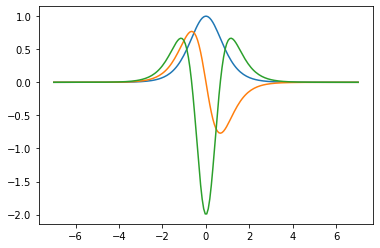

In [21]:
from jax import vmap

x = jnp.linspace(-7, 7, 200)

plt.plot(x, vmap(grad(jnp.tanh), in_axes=0)(x),
         x, vmap(grad(grad(jnp.tanh)), in_axes=0)(x),
         x, vmap(grad(grad(grad(jnp.tanh))), in_axes=0)(x))
plt.show()

### Using `optax` for optimisation

JAX provides a variety of features that are beneficial to ML and scientific computing in general. 
However, at the time of writing, JAX is still in an experimental phase and incorporates some programming techniques many might not be familiar with.
This section aims to provide an overview of bugs and issues we find with JAX and how to deal with them.
Some issues occur due to the nature of JAX being a more mid-level framework as opposed to Tensorflow or PyTorch.
Others might just be a result of JAX still being a fairly new framework which requires some work.

>


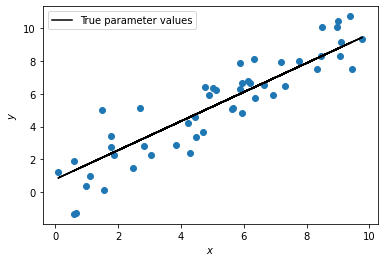

In [39]:
# get linear regression data
def f(x, a, b):
    return a*x+b

npoints = 50
areal = 1.0
breal = 0.0
sigmareal = 1.0
xdata = np.random.uniform(low=0.0, high=10.0, size=npoints)
ydata = f(xdata, areal, breal) + np.random.normal(0, sigmareal, size=npoints)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, params['a']*xdata + params['b'], color='black', label='True parameter values')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [23]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 32.3 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 


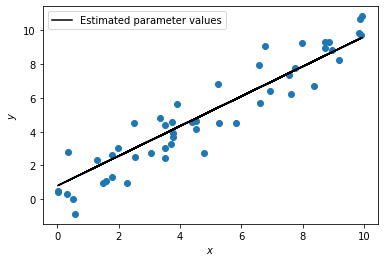

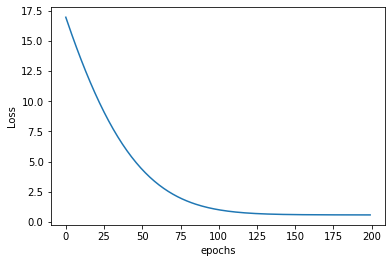

In [38]:
import optax

# propose values 
params = {'a':0.0,
          'b':0.0}

start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(params)

# specify number of training step
n_steps = 200

# specify the loss function
loss_fn = lambda params, x, y: jnp.mean(optax.l2_loss(params['a']*x + params['b'], y)) # optax.loss does not batch

losses = []

for i in range(n_steps):
    value, grads = jax.value_and_grad(loss_fn)(params, xdata, ydata)
    losses.append(value)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, params['a']*xdata + params['b'], color='black', label='Estimated parameter values')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

plt.plot(losses)
plt.xlabel(r'epochs')
plt.ylabel(r'Loss')
plt.show()

### lax.scan

In [25]:
from jax import lax

a = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5])

# using the jax version of cumsum
jax_cumsum = jnp.cumsum(a)
print(f'JAX version: {jax_cumsum}')

# writing a custom version of cumsum
def cumsum(curr, new):
    curr = curr + new
    return curr, curr  # ("carryover", "accumulated")

init = 0
final, result = lax.scan(cumsum, init, a)
print(f'Custom version with lax.scan: {result}')

JAX version: [ 3  4  8  9 14 23 25 31 36]
Custom version with lax.scan: [ 3  4  8  9 14 23 25 31 36]


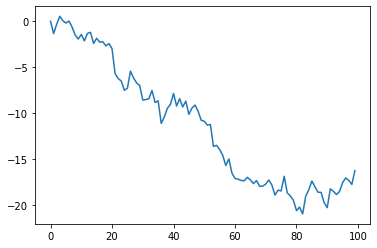

In [29]:
from functools import partial
import jax
from jax import vmap, lax

key = jax.random.PRNGKey(123)

# simulate trajectory
def draw(prev_val, key):
    new = prev_val + jax.random.normal(key)
    return new, prev_val

# simulate a Gaussian Random walk
def grw(key, num_steps):
    keys = jax.random.split(key, num_steps)
    final, draws = lax.scan(draw, 0.0, keys)
    return final, draws

final, trajectory = grw(key, num_steps=100)
plt.plot(trajectory)

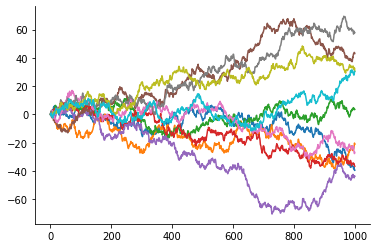

In [32]:
# simulate multiple Gaussian Random walks
def multiple_grw(key, num_realizations, grw_draw):
    keys = jax.random.split(key, num_realizations)
    grw = partial(grw_draw, num_steps=1000)

    final, trajectories = vmap(grw)(keys)
    return final, trajectories

final, trajectories = multiple_grw(key, num_realizations=20, grw_draw=grw)

import seaborn as sns
fig, ax = plt.subplots()

for trajectory in trajectories[0:10]:
    ax.plot(trajectory)
sns.despine()

## JAX Pitfalls

### `vmap` stuff

In [ ]:
# simulate 1 GR walk
key = jax.random.PRNGKey(1)
GW_noise_1 = jax.random.normal(key=key, shape=(10,))

# simulate 10 GR walks
keys = jax.random.split(key, num=10)
GW_noise_10 = vmap(jax.random.normal, in_axes=(0, None))(keys, (10,))

`jit` stuff

In [ ]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

jitted_f = jit(f)

jitted_f(jnp.array([2., 3., 4.]), 2)

In [ ]:
jitted_f = jit(f, static_argnums=(1,))

jitted_f(jnp.array([2., 3., 4.]), 2)

Discontinuous functions in `JAX`

In [ ]:
x = jnp.linspace(-1, 1, 100)

plt.plot(x, jnp.abs(x))
plt.show()

In [ ]:
grad(jnp.abs)(0.)